#installing dependencies

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Wed Oct 16 07:47:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [ ]:
!pip install -q -U transformers==4.12.2 datasets
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and i

In [ ]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!git clone https://github.com/mahmoudnabil/ASTD
!git clone https://github.com/nora-twairesh/AraSenti
!git clone https://github.com/mohamedadaly/LABR
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unrar x '/content/HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Let's download some Arabic text classification datasets

# Wandb

In [ ]:
# !pip install -q -U wandb
import wandb

from google.colab import userdata
userdata.get('w_b_scerts')

wb_token = '0b9ef567374cf5ac9ad70183a7a95a810f76ed5d'
# 0b9ef567374cf5ac9ad70183a7a95a810f76ed5d
wandb.login(key=wb_token)
run = wandb.init(
    project=' Sentiment Analysis using BERT',
    job_type="training",
    anonymous="allow")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahmed-mostafa22200028 (crime). Use `wandb login --relogin` to force relogin


#Creating training datasets

In [ ]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [ ]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.

##HARD - Balanced

In [ ]:
df_HARD = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["review","rating"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    5: 'POS',
    4: 'POS',
    2: 'NEG',
    1: 'NEG'
}

df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = ['NEG', 'POS']

data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
all_datasets.append(data_Hard)

label
2    38467
4    26450
5    26399
1    14382
Name: count, dtype: int64


##ASTD- Unbalanced

In [ ]:
df_ASTD_UN = pd.read_csv("/content/ASTD/data/Tweets.txt", sep="\t", header=None)
df_ASTD_UN.columns = [DATA_COLUMN, LABEL_COLUMN]
df_ASTD_UN = df_ASTD_UN[df_ASTD_UN[LABEL_COLUMN]!= 'OBJ']
train_ASTD_UN, test_ASTD_UN = train_test_split(df_ASTD_UN, test_size=0.2, random_state=42)
label_list_ASTD_UN = list(df_ASTD_UN[LABEL_COLUMN].unique())
print(label_list_ASTD_UN)
print(df_ASTD_UN[LABEL_COLUMN].value_counts())

data_ASTD_UN = CustomDataset("ASTD-Unbalanced", train_ASTD_UN, test_ASTD_UN, label_list_ASTD_UN)
all_datasets.append(data_ASTD_UN)

['POS', 'NEG', 'NEUTRAL']
label
NEG        1642
NEUTRAL     805
POS         777
Name: count, dtype: int64


In [ ]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced


## ArSAS

In [ ]:
df_ArSAS = pd.read_csv("/content/ArSAS..txt", sep="\t",encoding='utf-8')
df_ArSAS = df_ArSAS[["Tweet_text","Sentiment_label"]]  # we are interested in rating and review only
df_ArSAS.columns = [DATA_COLUMN, LABEL_COLUMN]
print("Total length: ", len(df_ArSAS))
print(df_ArSAS[LABEL_COLUMN].value_counts())

label_list_ArSAS = list(df_ArSAS[LABEL_COLUMN].unique())
print(label_list_ArSAS)

train_ArSAS, test_ArSAS = train_test_split(df_ArSAS, test_size=0.2, random_state=42)
print("Training length: ", len(train_ArSAS))
print("Testing length: ", len(test_ArSAS))
data_ArSAS = CustomDataset("ArSAS", train_ArSAS, test_ArSAS, label_list_ArSAS)
all_datasets.append(data_ArSAS)

Total length:  19897
label
Negative    7384
Neutral     6894
Positive    4400
Mixed       1219
Name: count, dtype: int64
['Positive', 'Negative', 'Neutral', 'Mixed']
Training length:  15917
Testing length:  3980


#Trainer

Start the training procedure

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy
from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [ ]:
for x in all_datasets:
  print(x.name)

HARD
ASTD-Unbalanced
ArSAS


In [ ]:
# select a dataset
dataset_name = 'ArSAS'
# select a model from the hugging-face model-hub https://huggingface.com/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter'

In [ ]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)

# Access the 'train' and 'test' splits using dictionary-like indexing
selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [ ]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['# بطولات - " ميرور " : محمد صلاح صفقة الموسم يتفوق على لاعبي البريمرليج [رابط]',
 'أعجبني فيديو على [رابط] هدفين محمد صلاح واسيست رائع ضد وستهام',
 'تصريح # قطر _ ساندويتش يعكس حالة الافاقه من حلم العضامية التي كانت تعيشه الحكومة القطرية ايام الربيع العربي المحرق وانها بدأت تعرف حجمها ! بقي الان ان تفهم ان لامجال لكذبة الحياد فافعالها السابقة تدينها ! وان تعي ان عمقها عربي خليجي سني والمهادنة مع شريفة لن يجعلها بعيدة عن اطماعها',
 'هم اهل للغش والمرضوالدولة تبي تطلعهمولا تنسى أزمة الخليجكل الخليج قاموا مع السعودية الا السودانولا نسيت ؟ يلا رد ياحرمه 😂 😂',
 'الكل يعلم أن جبهه النصره أستخدمت اللأسلحه الكيماويه بخان شيخون والدول التى تتهم سوريا هى من نقل السلاح الكيماوى من ليبيا لتركيا لجبهه النصره # كلاب الربيع العربى يدعمون الارهاب حتى اليوم [رابط]',
 '# سبق | ناصر حسان يشكر الرئيس # السيسي ويؤكد أنه سيكون سفير مصر بالخارج # منتدي _ شباب _ العالم # حفل _ الختام # weneedtotalk [رابط]',
 '# خالد _ عليلاتكن حمدين صباحي',
 '1 - الشعب اليمني قام بثورة ضد علي صالح 2 - علي صالح قاتلهم واهلك 

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


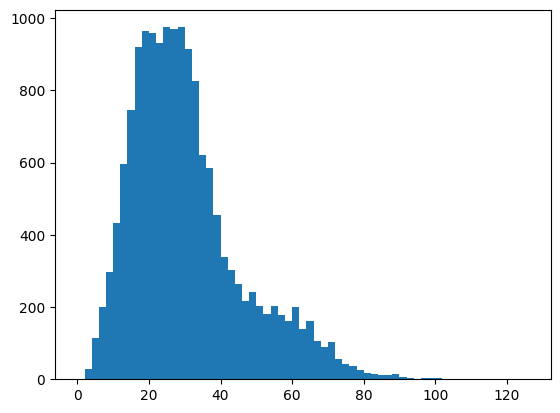

Testing Sentence Lengths: 


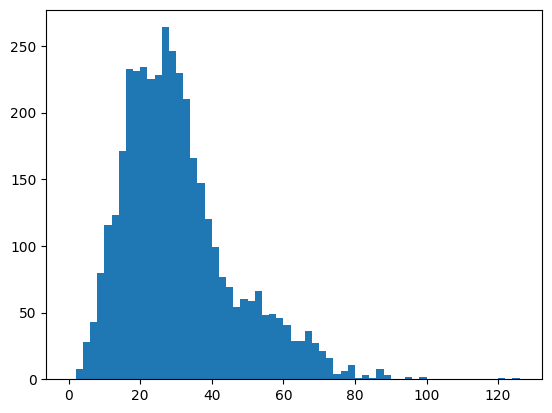

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [ ]:
max_len = 256

In [ ]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  7
Truncated testing sequences:  7


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Mixed': 3}


Check the dataset output

In [ ]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 10, 12279, 19, 9, 51185, 9, 31, 582, 3173, 5987, 2095, 27989, 323, 5518, 9435, 420, 1258, 64, 3879, 66, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Create a function that return a pretrained model ready to do classification

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'accuracy': acc,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
  }

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [ ]:
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 1,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#start the training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,No log,0.537795,0.619739,0.795477,0.676881,0.629477


TrainOutput(global_step=497, training_loss=0.6193522831323881, metrics={'train_runtime': 772.0072, 'train_samples_per_second': 20.618, 'train_steps_per_second': 0.644, 'total_flos': 2092296683323392.0, 'train_loss': 0.6193522831323881, 'epoch': 0.9989949748743718})

In [ ]:
# Save the fine-tuned model
new_model = "/content/output_model_directory"
trainer.model.save_pretrained(new_model)
wandb.finish()
# model_init.config.use_cache = True

eval/accuracy,▁
eval/loss,▁
eval/macro_f1,▁
eval/macro_precision,▁
eval/macro_recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
eval/accuracy,0.79548


AttributeError: 'function' object has no attribute 'config'

Save the model, the tokenizer and the config

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

{0: 'Positive', 1: 'Negative', 2: 'Neutral', 3: 'Mixed'}


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
#copy the model to drive
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


## predict using the saved model

In [ ]:
from transformers import pipeline

In [ ]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
pipe("الفلم يبدو مقلق نوعا ما ")

[[{'label': 'Positive', 'score': 0.002278053667396307},
  {'label': 'Negative', 'score': 0.9816712737083435},
  {'label': 'Neutral', 'score': 0.0063409507274627686},
  {'label': 'Mixed', 'score': 0.009709763340651989}]]

# K-fold

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [ ]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [ ]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [ ]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

Starting Fold Num:  0


Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.568965,0.604957,0.789259
1,No log,0.559475,0.609178,0.789887


***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_0/checkpoint-99
Configuration saved in ./train_0/checkpoint-99/config.json
Model weights saved in ./train_0/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_0/checkpoint-198
Configuration saved in ./train_0/checkpoint-198/config.json
Model weights saved in ./train_0/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_0/checkpoint-198 (score: 0.6091782449718879).
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128


Saving model checkpoint to ./train_0/best_model
Configuration saved in ./train_0/best_model/config.json


{'eval_loss': 0.5594748258590698, 'eval_macro_f1': 0.6091782449718879, 'eval_accuracy': 0.7898869346733668, 'eval_runtime': 12.2048, 'eval_samples_per_second': 260.881, 'eval_steps_per_second': 2.048, 'epoch': 1.99}


Model weights saved in ./train_0/best_model/pytorch_model.bin
tokenizer config file saved in ./train_0/best_model/tokenizer_config.json
Special tokens file saved in ./train_0/best_model/special_tokens_map.json


New Best Model Found!
Starting Fold Num:  1


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.588928,0.594138,0.772613
1,No log,0.567939,0.618273,0.783291


***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_1/checkpoint-99
Configuration saved in ./train_1/checkpoint-99/config.json
Model weights saved in ./train_1/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128
Saving model checkpoint to ./train_1/checkpoint-198
Configuration saved in ./train_1/checkpoint-198/config.json
Model weights saved in ./train_1/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_1/checkpoint-198 (score: 0.6182733689687013).
***** Running Evaluation *****
  Num examples = 3184
  Batch size = 128


Saving model checkpoint to ./train_1/best_model
Configuration saved in ./train_1/best_model/config.json


{'eval_loss': 0.5679389238357544, 'eval_macro_f1': 0.6182733689687013, 'eval_accuracy': 0.7832914572864321, 'eval_runtime': 12.1067, 'eval_samples_per_second': 262.996, 'eval_steps_per_second': 2.065, 'epoch': 1.99}


Model weights saved in ./train_1/best_model/pytorch_model.bin
tokenizer config file saved in ./train_1/best_model/tokenizer_config.json
Special tokens file saved in ./train_1/best_model/special_tokens_map.json


New Best Model Found!
Starting Fold Num:  2


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.585371,0.609818,0.781653
1,No log,0.563712,0.616816,0.792020


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_2/checkpoint-99
Configuration saved in ./train_2/checkpoint-99/config.json
Model weights saved in ./train_2/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_2/checkpoint-198
Configuration saved in ./train_2/checkpoint-198/config.json
Model weights saved in ./train_2/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_2/checkpoint-198 (score: 0.6168164037322856).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_2/best_model
Configuration saved in ./train_2/best_model/config.json


{'eval_loss': 0.5637116432189941, 'eval_macro_f1': 0.6168164037322856, 'eval_accuracy': 0.7920201068174678, 'eval_runtime': 12.0716, 'eval_samples_per_second': 263.677, 'eval_steps_per_second': 2.071, 'epoch': 1.99}


Model weights saved in ./train_2/best_model/pytorch_model.bin
tokenizer config file saved in ./train_2/best_model/tokenizer_config.json
Special tokens file saved in ./train_2/best_model/special_tokens_map.json


Starting Fold Num:  3


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.579523,0.603829,0.786993
1,No log,0.574080,0.627161,0.793277


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_3/checkpoint-99
Configuration saved in ./train_3/checkpoint-99/config.json
Model weights saved in ./train_3/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_3/checkpoint-198
Configuration saved in ./train_3/checkpoint-198/config.json
Model weights saved in ./train_3/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_3/checkpoint-198 (score: 0.6271605094588185).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_3/best_model
Configuration saved in ./train_3/best_model/config.json


{'eval_loss': 0.5740800499916077, 'eval_macro_f1': 0.6271605094588185, 'eval_accuracy': 0.7932767829092051, 'eval_runtime': 12.0905, 'eval_samples_per_second': 263.264, 'eval_steps_per_second': 2.068, 'epoch': 1.99}


Model weights saved in ./train_3/best_model/pytorch_model.bin
tokenizer config file saved in ./train_3/best_model/tokenizer_config.json
Special tokens file saved in ./train_3/best_model/special_tokens_map.json


New Best Model Found!
Starting Fold Num:  4


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.564324,0.610088,0.794848
1,No log,0.550712,0.614446,0.792963


***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_4/checkpoint-99
Configuration saved in ./train_4/checkpoint-99/config.json
Model weights saved in ./train_4/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128
Saving model checkpoint to ./train_4/checkpoint-198
Configuration saved in ./train_4/checkpoint-198/config.json
Model weights saved in ./train_4/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_4/checkpoint-198 (score: 0.6144461566641799).
***** Running Evaluation *****
  Num examples = 3183
  Batch size = 128


Saving model checkpoint to ./train_4/best_model
Configuration saved in ./train_4/best_model/config.json


{'eval_loss': 0.5507118701934814, 'eval_macro_f1': 0.6144461566641799, 'eval_accuracy': 0.7929626138862708, 'eval_runtime': 12.0522, 'eval_samples_per_second': 264.101, 'eval_steps_per_second': 2.074, 'epoch': 1.99}


Model weights saved in ./train_4/best_model/pytorch_model.bin
tokenizer config file saved in ./train_4/best_model/tokenizer_config.json
Special tokens file saved in ./train_4/best_model/special_tokens_map.json


In [ ]:
all_results

[{'epoch': 1.99,
  'eval_accuracy': 0.7898869346733668,
  'eval_loss': 0.5594748258590698,
  'eval_macro_f1': 0.6091782449718879,
  'eval_runtime': 12.2048,
  'eval_samples_per_second': 260.881,
  'eval_steps_per_second': 2.048},
 {'epoch': 1.99,
  'eval_accuracy': 0.7832914572864321,
  'eval_loss': 0.5679389238357544,
  'eval_macro_f1': 0.6182733689687013,
  'eval_runtime': 12.1067,
  'eval_samples_per_second': 262.996,
  'eval_steps_per_second': 2.065},
 {'epoch': 1.99,
  'eval_accuracy': 0.7920201068174678,
  'eval_loss': 0.5637116432189941,
  'eval_macro_f1': 0.6168164037322856,
  'eval_runtime': 12.0716,
  'eval_samples_per_second': 263.677,
  'eval_steps_per_second': 2.071},
 {'epoch': 1.99,
  'eval_accuracy': 0.7932767829092051,
  'eval_loss': 0.5740800499916077,
  'eval_macro_f1': 0.6271605094588185,
  'eval_runtime': 12.0905,
  'eval_samples_per_second': 263.264,
  'eval_steps_per_second': 2.068},
 {'epoch': 1.99,
  'eval_accuracy': 0.7929626138862708,
  'eval_loss': 0.5507118

In [ ]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.6171749367591747

After checking for the best hyper parameters you should use the regular training section and retrain the model with the parameters that you had here.

Or Ensemble the models together.

## Ensemble all the cross validation models

In [ ]:
from transformers import pipeline
import more_itertools

In [ ]:
inv_label_map = { v:k for k, v in label_map.items()}

Load some file which has text that we need to run inference on.
I will use the test set for that

In [ ]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [ ]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

loading configuration file train_0/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:910: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
loading configuration file train_1/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gel

0it [00:00, ?it/s]

loading configuration file train_2/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

loading configuration file train_3/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

loading configuration file train_4/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Positive",
    "1": "Negative",
    "2": "Neutral",
    "3": "Mixed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Mixed": 3,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
 

0it [00:00, ?it/s]

In [ ]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [ ]:
cross_val_df['preds'] = final_labels
cross_val_df['sentiment_score'] = final_scores

In [ ]:
cross_val_df['preds'].value_counts()

Negative    1603
Neutral     1433
Positive     932
Mixed         12
Name: preds, dtype: int64

In [ ]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

              precision    recall  f1-score   support

       Mixed       0.42      0.02      0.04       226
    Negative       0.80      0.89      0.84      1443
     Neutral       0.83      0.85      0.84      1408
    Positive       0.73      0.75      0.74       903

    accuracy                           0.79      3980
   macro avg       0.69      0.63      0.61      3980
weighted avg       0.77      0.79      0.77      3980

